### annotation 파일 읽어들여 spacing 통일 전후 volume 추정값 비교

In [1]:
import os
import monai
import nibabel as nib
import numpy as np
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
)
import pandas as pd
import matplotlib.pyplot as plt

# Enable deterministic training for reproducibility
monai.config.print_config()
monai.utils.set_determinism(seed=0)

def read_nifti_spacing_and_mask_count(nifti_file_path):
    try:
        # NIfTI 파일 열기
        img = nib.load(nifti_file_path)

        # spacing 정보 추출
        spacing = img.header.get_zooms()
        mask_voxel_count = np.count_nonzero(img.get_fdata()!=0)
        return mask_voxel_count, spacing[0], spacing[1], spacing[2]
    except Exception as e:
        print(f"Error reading NIfTI file: {str(e)}")
        return None

# Define a function to calculate the volume
def calculate_volume(mask_voxel_count, pixel_spacing_x, pixel_spacing_y, slice_gap):
#     return np.round((mask_voxel_count * pixel_spacing_x * pixel_spacing_y * slice_gap)/1000, 2)  ## mm3 to cc
    return (mask_voxel_count * pixel_spacing_x * pixel_spacing_y * slice_gap)/1000


directory_path = "/data/hanyang_Prostate/50_example/trim/sl_data/centerCrop_350_350_200/label_2_trim/"#"/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/"
class_name = 2

# if class_name == 1:
datasets = "/data/hanyang_Prostate/50_example/trim/sl_data/centerCrop_350_350_200/dataset_fold_testjinjin.json"
val_files = load_decathlon_datalist(datasets, True, "test")
# if args.class_name == 2:
#     datasets = args.root_path + "/dataset_2_fold{}.json".format(args.fold)
#     print("transition zone train :dataset_2.json")
        
files = load_decathlon_datalist(datasets, True, "training")
if class_name == 1:
    pass
if class_name == 2:
    # '/label_trim/'을 '/label_2_trim/'으로 치환
    for file_info in files:
        file_info['label'] = file_info['label'].replace('/label_trim/', '/label_2_trim/')
    for file_info in val_files:
        file_info['label'] = file_info['label'].replace('/label_trim/', '/label_2_trim/')

transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAI"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.8, 0.8, 0.8),
            mode=("bilinear", "nearest"),
        ),
    ]
)

db = CacheDataset(
    data=files, transform=transforms, cache_num=6, cache_rate=1.0, num_workers=4
)

for _ in range(len(db)):
       
    mask_voxel_count2 = np.count_nonzero(db[_]['label'][0]!=0)
    volume2 = calculate_volume(mask_voxel_count2, transforms.transforms[-1].spacing_transform.pixdim[0], transforms.transforms[-1].spacing_transform.pixdim[1], transforms.transforms[-1].spacing_transform.pixdim[2])
    no = db[_]['label_meta_dict']['filename_or_obj'].split('/')[-1][:8]
    
    original_nifti_file_path=''
    # 디렉토리 탐색
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if no in file:
                # 검색한 문자열을 포함한 파일의 전체 경로 출력
                original_nifti_file_path = os.path.join(root, file)
#                 print("\t Original file name:", original_nifti_file_path)
                
    mask_voxel_count, pixel_spacing_x, pixel_spacing_y, slice_gap = read_nifti_spacing_and_mask_count(original_nifti_file_path)
    volume = calculate_volume(mask_voxel_count, pixel_spacing_x, pixel_spacing_y, slice_gap)
    
    print(f"No: {no}, Volume: {np.round(volume,1)} (cc), Transformed Volume: {np.round(volume2,1)} (cc)")
    print(f"\t Original Pixel Spacing (x): {np.round(float(pixel_spacing_x),3)}")
    print(f"\t Original Pixel Spacing (y): {np.round(float(pixel_spacing_y),3)}")
    print(f"\t Original Slice Gap: {np.round(float(slice_gap),3)}")
    print('------------------------------------------------------')
print('done')

/root/anaconda3/envs/prostate/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.0
Numpy version: 1.23.1
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /root/anaconda3/envs/prostate/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.2
Pillow version: 6.2.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing t

/root/anaconda3/envs/prostate/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 6/6 [00:57<00:00,  9.63s/it]


No: 02953538, Volume: 23.2 (cc), Transformed Volume: 22.8 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02953540, Volume: 23.2 (cc), Transformed Volume: 23.2 (cc)
	 Original Pixel Spacing (x): 0.816
	 Original Pixel Spacing (y): 0.816
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02953784, Volume: 15.0 (cc), Transformed Volume: 14.8 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02953958, Volume: 12.7 (cc), Transformed Volume: 12.7 (cc)
	 Original Pixel Spacing (x): 0.801
	 Original Pixel Spacing (y): 0.801
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02954359, Volume: 14.9 (cc), Transformed Volume: 14.5 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	

No: 02573669, Volume: 17.5 (cc), Transformed Volume: 17.2 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02603745, Volume: 7.0 (cc), Transformed Volume: 6.8 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02610498, Volume: 9.0 (cc), Transformed Volume: 9.3 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02744296, Volume: 15.6 (cc), Transformed Volume: 15.7 (cc)
	 Original Pixel Spacing (x): 0.866
	 Original Pixel Spacing (y): 0.866
	 Original Slice Gap: 0.8
------------------------------------------------------
No: 02786444, Volume: 10.2 (cc), Transformed Volume: 9.9 (cc)
	 Original Pixel Spacing (x): 0.782
	 Original Pixel Spacing (y): 0.782
	 Orig

### 테스트셋에 대한 fold별 performace 비교

In [2]:
### with unifying spacing
# import numpy as np

dices=np.array([0.7716840967887976,0.7730853397642768,0.7883300720396352,0.769689508589045,0.766813006438379])*100
print("DICE")
print("Mean:", dices.mean(), "STD:", dices.std())

jaccs=np.array([0.6348988494520279,0.63829855086555,0.6534395984719954,0.630267706276064,0.6265952359852804])*100
print("Jacc")
print("Mean:", jaccs.mean(), "STD:", jaccs.std())

HDs=np.array([7.759057863710498,6.719706437682912,6.610962742643399,6.114125863435851,6.724228630621413])
print("HD")
print("Mean:", HDs.mean(), "STD:", HDs.std())

ASDs=np.array([2.4643982664493205,2.640582980650306,2.429695920718842,2.752254900120374,2.8966560331830675])
print("ASD")
print("Mean:", ASDs.mean(), "STD:", ASDs.std())

DICE
Mean: 77.39204047240267 STD: 0.7506697160676162
Jacc
Mean: 63.66999882101836 STD: 0.9268164041635271
HD
Mean: 6.785616307618815 STD: 0.5361164622273705
ASD
Mean: 2.636717620224382 STD: 0.1752048665648783


In [3]:
# ### without unifying spacing
# # import numpy as np

# dices_wo=np.array([0.877315132509052,0.8947155193753472,0.8493276590430133,0.8880653421659714,0.8827005646887409])*100
# print("DICE")
# print("Mean:", dices_wo.mean(), "STD:", dices_wo.std())

# jaccs_wo=np.array([0.7850897178782225,0.810410356613118,0.7412313021694275,0.8000067969596143,0.791623883469603])*100
# print("Jacc")
# print("Mean:", jaccs_wo.mean(), "STD:", jaccs_wo.std())

# HDs_wo=np.array([9.04842243040798,4.07103053293988,5.733904265350592,4.696959505213359,4.716420489648665])
# print("HD")
# print("Mean:", HDs_wo.mean(), "STD:", HDs_wo.std())

# ASDs_wo=np.array([1.7287001094550327,1.545721189761277,2.2164615567937025,1.8076034611352134,1.7375953647909803])
# print("ASD")
# print("Mean:", ASDs_wo.mean(), "STD:", ASDs_wo.std())

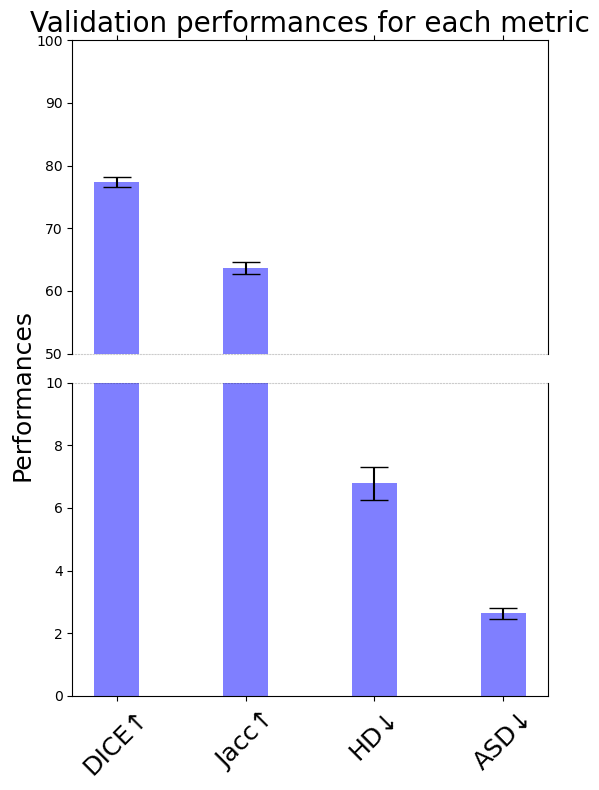

In [4]:
# import matplotlib.pyplot as plt

# Create lists for the plot
materials = ['DICE↑', 'Jacc↑', 'HD↓', 'ASD↓']
x_pos = np.arange(len(materials))
means = [dices.mean(), jaccs.mean(), HDs.mean(), ASDs.mean()]
errors = [dices.std(), jaccs.std(), HDs.std(), ASDs.std()]

# means_wo = [dices_wo.mean(), jaccs_wo.mean(), HDs_wo.mean(), ASDs_wo.mean()]
# errors_wo = [dices_wo.std(), jaccs_wo.std(), HDs_wo.std(), ASDs_wo.std()]

# Dodged Bar Chart (with same X coordinates side by side)
bar_width = 0.35
alpha = 0.5

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
p1_1 = ax1.bar(x_pos, means, 
             bar_width, yerr=errors, 
             color='b', 
             ecolor='black',
             alpha=alpha,
             capsize=10,
             label='w unifying spacing')
p1_2 = ax2.bar(x_pos, means, 
             bar_width, yerr=errors, 
             color='b', 
             ecolor='black',
             alpha=alpha,
             capsize=10,
             label='w unifying spacing')

# p2_1 = ax1.bar(x_pos + bar_width, means_wo, 
#              bar_width, yerr=errors_wo,
#              color='r',
#              ecolor='black',
#              alpha=alpha,
#              capsize=10,
#              label='wo unifying spacing')

# p2_2 = ax2.bar(x_pos + bar_width, means_wo, 
#              bar_width, yerr=errors_wo,
#              color='r',
#              ecolor='black',
#              alpha=alpha,
#              capsize=10,
#              label='wo unifying spacing')

ax1.set_title('Validation performances for each metric', fontsize=20)
# ylabel을 그림 전체에 대한 위치를 지정
fig.text(0, 0.5, 'Performances', va='center', rotation='vertical', fontsize=18)
# ax1.set_ylabel('Performances', fontsize=18)
ax1.set_ylim(50,100)
ax2.set_ylim(0,10)

# hide the spines between ax and ax2
# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linestyle('dotted')  # 점선
ax1.spines['bottom'].set_alpha(0.2)
ax2.spines['top'].set_linestyle('dotted')  # 점선
ax2.spines['top'].set_alpha(0.2)

ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xticks(x_pos)
ax2.set_xticklabels(materials, rotation=45, fontsize=18)
# ax1.legend((p1_1[0], p2_1[0]), ('w unifying spacing', 'wo unifying spacing'), fontsize=15)
# ax1.legend((p1_2[0], p2_2[0]), ('w unifying spacing', 'wo unifying spacing'), fontsize=15)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### 학습셋에 대한 fold별 performace 비교

In [5]:
### with unifying spacing
# import numpy as np

dices=np.array([0.8045388253405179,0.8911014539665796,0.8885153819121869,0.885109888983641,0.8861082114095649])*100
print("DICE")
print("Mean:", dices.mean(), "STD:", dices.std())

jaccs=np.array([0.6791701659876048,0.8049745030324447,0.8024199937833515,0.7956797650879001,0.7977758141243092])*100
print("Jacc")
print("Mean:", jaccs.mean(), "STD:", jaccs.std())

HDs=np.array([7.589699292028871,3.1676102052165604,3.2091139083251528,3.126202058395505,3.2220565764060516])
print("HD")
print("Mean:", HDs.mean(), "STD:", HDs.std())

ASDs=np.array([2.104424058009711,1.3673295682522877,1.40001360769376,1.451053148675656,1.3804626896634817])
print("ASD")
print("Mean:", ASDs.mean(), "STD:", ASDs.std())

DICE
Mean: 87.10747523224981 STD: 3.3332458270570617
Jacc
Mean: 77.60040484031222 STD: 4.852841189468502
HD
Mean: 4.062936408074428 STD: 1.7637022675846217
ASD
Mean: 1.5406566144589793 STD: 0.28331866346154977


In [6]:
# ### without unifying spacing
# # import numpy as np

# dices_wo=np.array([0.9398601734175902,0.954749765995212,0.933258719726231,0.9227202398251613,0.955771499829304])*100
# print("DICE")
# print("Mean:", dices_wo.mean(), "STD:", dices_wo.std())

# jaccs_wo=np.array([0.8871770692921922,0.9137093022463547,0.8755371405224164,0.8581712012195059,0.9154534377434551])*100
# print("Jacc")
# print("Mean:", jaccs_wo.mean(), "STD:", jaccs_wo.std())

# HDs_wo=np.array([13.136553371484691,3.5852982013915105,2.491785877950665,2.9364766524720105,1.860422333174053])
# print("HD")
# print("Mean:", HDs_wo.mean(), "STD:", HDs_wo.std())

# ASDs_wo=np.array([0.9535233111404582,0.7854481742172263,1.0373418458445687,1.1704371667219289,0.7934224747762416])
# print("ASD")
# print("Mean:", ASDs_wo.mean(), "STD:", ASDs_wo.std())

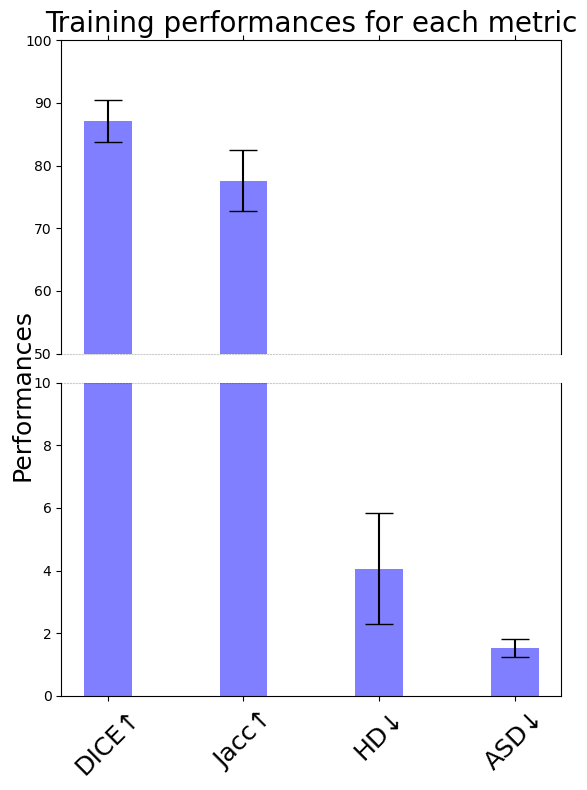

In [7]:
# import matplotlib.pyplot as plt

# Create lists for the plot
materials = ['DICE↑', 'Jacc↑', 'HD↓', 'ASD↓']
x_pos = np.arange(len(materials))
means = [dices.mean(), jaccs.mean(), HDs.mean(), ASDs.mean()]
errors = [dices.std(), jaccs.std(), HDs.std(), ASDs.std()]

# means_wo = [dices_wo.mean(), jaccs_wo.mean(), HDs_wo.mean(), ASDs_wo.mean()]
# errors_wo = [dices_wo.std(), jaccs_wo.std(), HDs_wo.std(), ASDs_wo.std()]

# Dodged Bar Chart (with same X coordinates side by side)
bar_width = 0.35
alpha = 0.5

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
p1_1 = ax1.bar(x_pos, means, 
             bar_width, yerr=errors, 
             color='b', 
             ecolor='black',
             alpha=alpha,
             capsize=10,
             label='w unifying spacing')
p1_2 = ax2.bar(x_pos, means, 
             bar_width, yerr=errors, 
             color='b', 
             ecolor='black',
             alpha=alpha,
             capsize=10,
             label='w unifying spacing')

# p2_1 = ax1.bar(x_pos + bar_width, means_wo, 
#              bar_width, yerr=errors_wo,
#              color='r',
#              ecolor='black',
#              alpha=alpha,
#              capsize=10,
#              label='wo unifying spacing')

# p2_2 = ax2.bar(x_pos + bar_width, means_wo, 
#              bar_width, yerr=errors_wo,
#              color='r',
#              ecolor='black',
#              alpha=alpha,
#              capsize=10,
#              label='wo unifying spacing')

ax1.set_title('Training performances for each metric', fontsize=20)
# ylabel을 그림 전체에 대한 위치를 지정
fig.text(0, 0.5, 'Performances', va='center', rotation='vertical', fontsize=18)
# ax1.set_ylabel('Performances', fontsize=18)
ax1.set_ylim(50,100)
ax2.set_ylim(0,10)

# hide the spines between ax and ax2
# ax1.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax1.spines['bottom'].set_linestyle('dotted')  # 점선
ax1.spines['bottom'].set_alpha(0.2)
ax2.spines['top'].set_linestyle('dotted')  # 점선
ax2.spines['top'].set_alpha(0.2)

ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax2.set_xticks(x_pos)
ax2.set_xticklabels(materials, rotation=45, fontsize=18)
# ax1.legend((p1_1[0], p2_1[0]), ('w unifying spacing', 'wo unifying spacing'), fontsize=15)
# ax1.legend((p1_2[0], p2_2[0]), ('w unifying spacing', 'wo unifying spacing'), fontsize=15)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

### Fold별 각각의 val set prediction에 대한 volume 추정

In [8]:
### /data/hanyang_Prostate/Prostate/prostate_1c_test_result/test/unet_10000_30000_fold1/ 
### 디렉토리 안에 있는 _gt.nii.gz파일을 읽어들여서 먼저 계산하고, 문자열 파싱해서 환자번호로 _pred.nii.gz 계산하고, 
###/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 안에서 
###문자열로 다시 파일이름 조회해서 진짜 gt파일상에서 volume 계산하여
###전부 리스트로 저장
### 세 리스트 a(가짜 gt), b(prediction), c(진짜 gt) 간 |a-b|와 |b-c|를 구하기, 평균이랑 분산도 내기
### 이철민 교수님께서 주신 excel 파일 읽어들여서 d 리스트 만들고 |a-d|와 |d-c|를 구하기, 평균이랑 분산도 내기
### TRUS_HP_201706_202206_20230904.xlsx ### 여기까지 구현됨

In [9]:
### 제일 잘한 모델로부터 다시 |a-b|, |b-c|, |a-d|, |d-c| 계산하기  ### 여기까지 구현됨
### correlation coef 구하기 r^2 구하기, least square 구하기(알파폴드논문에서 처럼)
### plotting은 어떨까?

In [10]:
# import pandas as pd

# Excel 초음파 파일 읽기
# df = pd.read_excel('./TRUS_HP_201706_202206_20230904.xlsx')
df = pd.read_excel('./TRUS_HP_201706_202206_20231013.xlsx', engine='openpyxl', dtype={'A': str})

# 제목 행 삭제
# df = df.iloc[1:]

# A열부터 50번째 열까지만 선택
df = df.iloc[:49]
# print(df)

# A열을 인덱스로 설정
# 'ID' 열을 문자열로 변환하고 8자리로 맞추기 위해 앞에 '0' 추가
df['ID'] = df['ID'].astype(str).str.zfill(8)
df.set_index('ID', inplace=True)
# df = df.dropna(subset=['Total volume \n(US)'])
df = df.dropna(subset=['TZ volume \n(US)'])
# print(df)
# print(df)
# H열의 데이터를 딕셔너리로 추출
# TRUS_total = df['Total volume \n(US)'].to_dict()
TRUS_tz = df['TZ volume \n(US)'].to_dict()

# 결과 출력
# print(len(TRUS_total.keys()))
print(len(TRUS_tz.keys()))

48


In [11]:
# import os
# import numpy as np

# 디렉토리 경로 설정
base_directory = '/data/hanyang_Prostate/Prostate/TZ_1c_test_result/test'
directory_paths = [os.path.join(base_directory, f'vnet_30000_fold{i}/test/') for i in range(1, 6)]
directory_path_realgt = '/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/TZ volume/'

# 초기화할 리스트
a_lists = [[] for _ in range(5)]  # 각 폴드의 volume_gt 리스트
b_lists = [[] for _ in range(5)]  # 각 폴드의 volume_pred 리스트
c_lists = [[] for _ in range(5)]  # 각 폴드의 volume_realgt 리스트
d_lists = [[] for _ in range(5)]  # 각 폴드의 volume_TRUS 리스트
cnt = 0
# 디렉토리별로 처리
for fold_idx, directory_path in enumerate(directory_paths, start=1):
    print("Directory: ", directory_path)
    # 디렉토리 내의 모든 파일 검색
    for filename in os.listdir(directory_path):
        # 파일 이름이 "_gt.nii.gz"로 끝나는 경우에만 처리
        if filename.endswith('_gt.nii.gz'):
            # 파일의 전체 경로 생성
            gt_file_path = os.path.join(directory_path, filename)
            
            # 해당 _gt 파일과 동일한 이름 구조를 가진 _pred 파일 찾기
            pred_filename = filename.replace('_gt.nii.gz', '_pred.nii.gz')
            pred_file_path = os.path.join(directory_path, pred_filename)
    
            # _pred 파일이 존재하면 계산 수행
            if os.path.exists(pred_file_path):
                # _gt 파일의 정보를 읽어오고 volume 계산
                mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt = read_nifti_spacing_and_mask_count(gt_file_path)
                volume_gt = calculate_volume(mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt)
                
                # _pred 파일의 정보를 읽어오고 volume 계산
                mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred = read_nifti_spacing_and_mask_count(pred_file_path)
                volume_pred = calculate_volume(mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred)
                
                # 검색할 문자열 설정
                a_value = filename.split("_")[1]
    
                # /data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 내의 파일 검색
                for realgt_filename in os.listdir(directory_path_realgt):
                    # 파일 이름에 검색할 문자열이 포함되어 있는지 확인
                    if a_value in realgt_filename:
                        mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt = read_nifti_spacing_and_mask_count(os.path.join(directory_path_realgt, realgt_filename))
                        volume_realgt = calculate_volume(mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt)
                        
                        # 값 저장
                        if a_value in TRUS_tz:
                            cnt += 1
                            a_lists[fold_idx - 1].append(volume_gt)
                            b_lists[fold_idx - 1].append(volume_pred)
                            c_lists[fold_idx - 1].append(volume_realgt)
                            d_lists[fold_idx - 1].append(TRUS_tz[a_value])
                            # 출력
                            print(f"No.: {a_value}")
                            print(f"\t Volume (TRUS_tz): {TRUS_tz[a_value]}")
                            print(f"\t Pixel Spacing X (realgt): {np.round(float(pixel_spacing_x_realgt),3)}")
                            print(f"\t Volume (realgt): {np.round(volume_realgt,1)}")
                            print(f"\t Pixel Spacing X (gt): {np.round(float(pixel_spacing_x_gt),3)}")
                            print(f"\t Volume (gt): {np.round(volume_gt,1)}")
                            print(f"\t Pixel Spacing X (pred): {np.round(float(pixel_spacing_x_pred),3)}")
                            print(f"\t Volume (pred): {np.round(volume_pred,1)}")
                            print("-----------------------------------------")
print(cnt)

Directory:  /data/hanyang_Prostate/Prostate/TZ_1c_test_result/test/vnet_30000_fold1/test/
No.: 00800131
	 Volume (TRUS_tz): 16.8
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 16.9
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 16.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.1
-----------------------------------------
No.: 00818049
	 Volume (TRUS_tz): 15.2
	 Pixel Spacing X (realgt): 0.755
	 Volume (realgt): 10.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 10.1
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 16.1
-----------------------------------------
No.: 00851016
	 Volume (TRUS_tz): 17.3
	 Pixel Spacing X (realgt): 0.709
	 Volume (realgt): 15.6
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 15.6
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 22.4
-----------------------------------------
No.: 01054688
	 Volume (TRUS_tz): 10.3
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 9.8
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 9.7
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 14.

No.: 02882776
	 Volume (TRUS_tz): 9.7
	 Pixel Spacing X (realgt): 0.74
	 Volume (realgt): 9.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 9.0
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 13.8
-----------------------------------------
No.: 02948957
	 Volume (TRUS_tz): 25.1
	 Pixel Spacing X (realgt): 0.74
	 Volume (realgt): 31.6
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 31.5
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.5
-----------------------------------------
No.: 02949843
	 Volume (TRUS_tz): 13.4
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 26.0
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 25.7
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 22.2
-----------------------------------------
No.: 02951189
	 Volume (TRUS_tz): 16.4
	 Pixel Spacing X (realgt): 0.709
	 Volume (realgt): 18.4
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 18.5
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 14.7
-----------------------------------------
No.: 02951192
	 Volume (TRUS_tz): 17.8
	 Pixel Sp

Fold 1:
|processed gt - gt| 평균: 0.1621189435666121
|processed gt - gt| 표준편차: 0.16979398099302367
|processed gt - prediction| 평균: 4.043776180770876
|processed gt - prediction| 표준편차: 2.4608373698767627
|prediction - gt| 평균: 3.9869029497197466
|prediction - gt| 표준편차: 2.5298581932595785

Fold 2:
|processed gt - gt| 평균: 0.18476179637428983
|processed gt - gt| 표준편차: 0.13830448487666777
|processed gt - prediction| 평균: 4.483697978214692
|processed gt - prediction| 표준편차: 3.1273032721191654
|prediction - gt| 평균: 4.494450294417867
|prediction - gt| 표준편차: 3.155320155820956

Fold 3:
|processed gt - gt| 평균: 0.1863071025511191
|processed gt - gt| 표준편차: 0.13380718471340972
|processed gt - prediction| 평균: 2.9432833315750146
|processed gt - prediction| 표준편차: 3.3118148959261404
|prediction - gt| 평균: 2.8997090636065317
|prediction - gt| 표준편차: 3.182435115856477

Fold 4:
|processed gt - gt| 평균: 0.13182158343722764
|processed gt - gt| 표준편차: 0.12133169019847606
|processed gt - prediction| 평균: 5.10924822840118

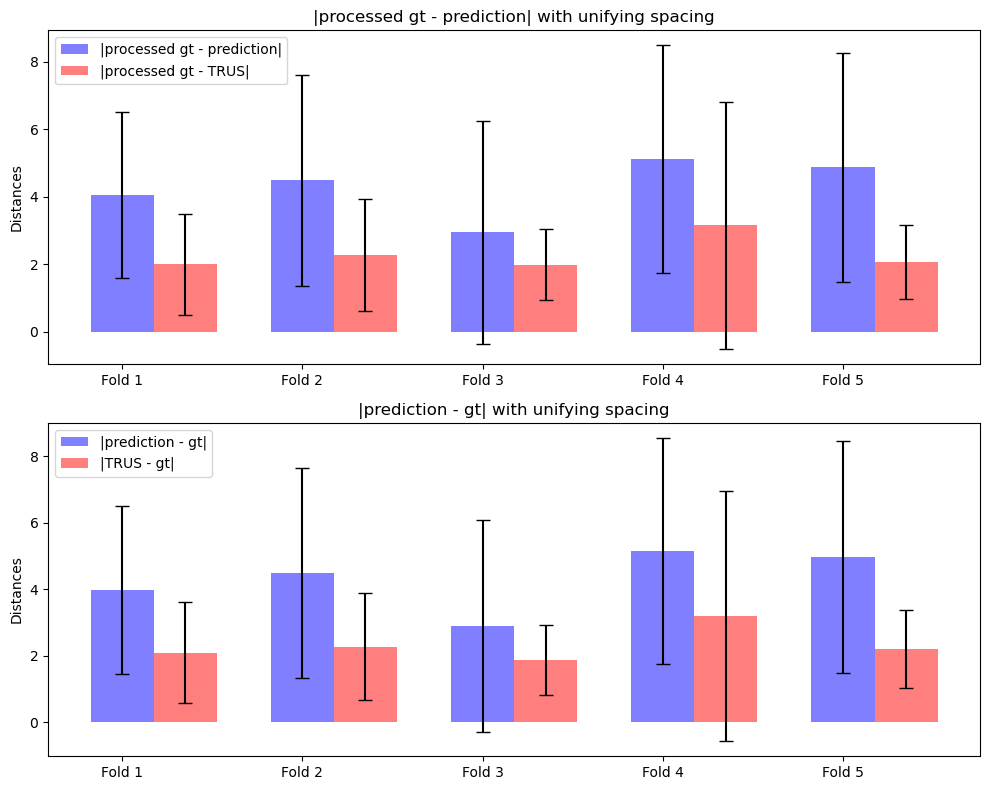

In [12]:
# 데이터 처리
mean_ac = []
std_ac = []

mean_ab = []
std_ab = []
mean_bc = []
std_bc = []
mean_ad = []
std_ad = []
mean_dc = []
std_dc = []

# Fold 수
num_folds = len(a_lists)

# fold별로 |a-b|와 |b-c| 계산
for fold_idx, (a_values, b_values, c_values) in enumerate(zip(a_lists, b_lists, c_lists), start=1):
    abs_diff_ac_fold = np.abs(np.array(a_values) - np.array(c_values))
    abs_diff_ab_fold = np.abs(np.array(a_values) - np.array(b_values))
    abs_diff_bc_fold = np.abs(np.array(b_values) - np.array(c_values))
    
    mean_ac_fold = np.mean(abs_diff_ac_fold)
    std_ac_fold = np.std(abs_diff_ac_fold)
    mean_ab_fold = np.mean(abs_diff_ab_fold)
    std_ab_fold = np.std(abs_diff_ab_fold)
    mean_bc_fold = np.mean(abs_diff_bc_fold)
    std_bc_fold = np.std(abs_diff_bc_fold)
    mean_ab.append(mean_ab_fold)
    std_ab.append(std_ab_fold)
    mean_bc.append(mean_bc_fold)
    std_bc.append(std_bc_fold)
    
    print(f"Fold {fold_idx}:")
    print(f"|processed gt - gt| 평균: {mean_ac_fold}")
    print(f"|processed gt - gt| 표준편차: {std_ac_fold}")
    print(f"|processed gt - prediction| 평균: {mean_ab_fold}")
    print(f"|processed gt - prediction| 표준편차: {std_ab_fold}")
    print(f"|prediction - gt| 평균: {mean_bc_fold}")
    print(f"|prediction - gt| 표준편차: {std_bc_fold}")
    print()

# fold별로 |a-d|와 |d-c| 계산 : fold마다 validation에 사용된 데이터가 다를거라서
for fold_idx, (a_values, d_values, c_values) in enumerate(zip(a_lists, d_lists, c_lists), start=1):
    abs_diff_ad_fold = np.abs(np.array(a_values) - np.array(d_values))
    abs_diff_dc_fold = np.abs(np.array(d_values) - np.array(c_values))
    
    mean_ad_fold = np.mean(abs_diff_ad_fold)
    std_ad_fold = np.std(abs_diff_ad_fold)
    mean_dc_fold = np.mean(abs_diff_dc_fold)
    std_dc_fold = np.std(abs_diff_dc_fold)
    mean_ad.append(mean_ad_fold)
    std_ad.append(std_ad_fold)
    mean_dc.append(mean_dc_fold)
    std_dc.append(std_dc_fold)
    
    print(f"Fold {fold_idx}:")
    print(f"|processed gt - TRUS| 평균: {mean_ad_fold}")
    print(f"|processed gt - TRUS| 표준편차: {std_ad_fold}")
    print(f"|TRUS - gt| 평균: {mean_dc_fold}")
    print(f"|TRUS - gt| 표준편차: {std_dc_fold}")
    print()
    
# Fold별 바 차트 그리기
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
bar_width = 0.35

# 첫 번째 plot
axes[0].bar(range(1, num_folds + 1), mean_ab, bar_width, yerr=std_ab, color='b', alpha=0.5, capsize=5, label='|processed gt - prediction|')
axes[0].bar([x + bar_width for x in range(1, num_folds + 1)], mean_ad, bar_width, color='r', yerr=std_ad, alpha=0.5, capsize=5, label='|processed gt - TRUS|')
axes[0].set_xticks(range(1, num_folds + 1))
axes[0].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
axes[0].set_ylabel('Distances')
axes[0].set_title('|processed gt - prediction| with unifying spacing')
axes[0].legend()

# 두 번째 plot
axes[1].bar(range(1, num_folds + 1), mean_bc, bar_width, yerr=std_bc, color='b', alpha=0.5, capsize=5, label='|prediction - gt|')
axes[1].bar([x + bar_width for x in range(1, num_folds + 1)], mean_dc, bar_width, yerr=std_dc, color='r', alpha=0.5, capsize=5, label='|TRUS - gt|')
axes[1].set_xticks(range(1, num_folds + 1))
axes[1].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
axes[1].set_ylabel('Distances')
axes[1].set_title('|prediction - gt| with unifying spacing')
axes[1].legend()

plt.tight_layout()
plt.show()

Mean: 4.290275747345822 STD: 0.7643235867454725)
Mean: 4.29905989787944 STD: 0.8076910104710482)


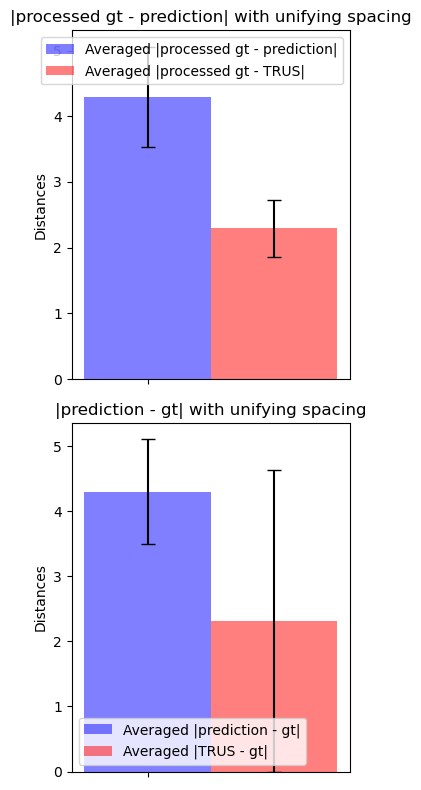

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(4, 8))
bar_width = 0.35
print(f'Mean: {np.mean(mean_ab)} STD: {np.std(mean_ab)})')
print(f'Mean: {np.mean(mean_bc)} STD: {np.std(mean_bc)})')

# 첫 번째 plot
axes[0].bar([1], [np.mean(mean_ab)], bar_width, yerr=[np.std(mean_ab)], color='b', alpha=0.5, capsize=5, label='Averaged |processed gt - prediction|')
axes[0].bar([1 + bar_width], [np.mean(mean_ad)], bar_width, color='r', yerr=[np.std(mean_ad)], alpha=0.5, capsize=5, label='Averaged |processed gt - TRUS|')
axes[0].set_xticks([1])
axes[0].set_xticklabels([''])
axes[0].set_ylabel('Distances')
axes[0].set_title('|processed gt - prediction| with unifying spacing')
axes[0].legend()

# 두 번째 plot
axes[1].bar([1], [np.mean(mean_bc)], bar_width, yerr=[np.std(mean_bc)], color='b', alpha=0.5, capsize=5, label='Averaged |prediction - gt|')
axes[1].bar([1 + bar_width], [np.mean(mean_dc)], bar_width, yerr=[np.mean(mean_dc)], color='r', alpha=0.5, capsize=5, label='Averaged |TRUS - gt|')
axes[1].set_xticks([1])
axes[1].set_xticklabels([''])
axes[1].set_ylabel('Distances')
axes[1].set_title('|prediction - gt| with unifying spacing')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# # import os
# # import numpy as np

# # 디렉토리 경로 설정
# base_directory = '/data/hanyang_Prostate/Prostate/prostate_1c_test_result/test_230922_wo_spacing/'
# directory_paths = [os.path.join(base_directory, f'vnet_30000_fold{i}/test/') for i in range(1, 6)]
# directory_path_realgt = '/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/'

# # 초기화할 리스트
# a_lists = [[] for _ in range(5)]  # 각 폴드의 volume_gt 리스트
# b_lists = [[] for _ in range(5)]  # 각 폴드의 volume_pred 리스트
# c_lists = [[] for _ in range(5)]  # 각 폴드의 volume_realgt 리스트
# d_lists = [[] for _ in range(5)]  # 각 폴드의 volume_TRUS 리스트
# cnt = 0
# # 디렉토리별로 처리
# for fold_idx, directory_path in enumerate(directory_paths, start=1):
#     print("Directory: ", directory_path)
#     # 디렉토리 내의 모든 파일 검색
#     for filename in os.listdir(directory_path):
#         # 파일 이름이 "_gt.nii.gz"로 끝나는 경우에만 처리
#         if filename.endswith('_gt.nii.gz'):
#             # 파일의 전체 경로 생성
#             gt_file_path = os.path.join(directory_path, filename)
            
#             # 해당 _gt 파일과 동일한 이름 구조를 가진 _pred 파일 찾기
#             pred_filename = filename.replace('_gt.nii.gz', '_pred.nii.gz')
#             pred_file_path = os.path.join(directory_path, pred_filename)
    
#             # _pred 파일이 존재하면 계산 수행
#             if os.path.exists(pred_file_path):
#                 # _gt 파일의 정보를 읽어오고 volume 계산
#                 mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt = read_nifti_spacing_and_mask_count(gt_file_path)
#                 volume_gt = calculate_volume(mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt)
                
#                 # _pred 파일의 정보를 읽어오고 volume 계산
#                 mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred = read_nifti_spacing_and_mask_count(pred_file_path)
#                 volume_pred = calculate_volume(mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred)
                
#                 # 검색할 문자열 설정
#                 a_value = filename.split("_")[1]
    
#                 # /data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 내의 파일 검색
#                 for realgt_filename in os.listdir(directory_path_realgt):
#                     # 파일 이름에 검색할 문자열이 포함되어 있는지 확인
#                     if a_value in realgt_filename:
#                         mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt = read_nifti_spacing_and_mask_count(os.path.join(directory_path_realgt, realgt_filename))
#                         volume_realgt = calculate_volume(mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt)
                        
#                         # 값 저장
#                         if a_value in TRUS:
#                             cnt += 1
#                             a_lists[fold_idx - 1].append(volume_gt)
#                             b_lists[fold_idx - 1].append(volume_pred)
#                             c_lists[fold_idx - 1].append(volume_realgt)
#                             d_lists[fold_idx - 1].append(TRUS[a_value])
#                             # 출력
#                             print(f"No.: {a_value}")
#                             print(f"\t Volume (TRUS): {TRUS[a_value]}")
#                             print(f"\t Pixel Spacing X (realgt): {np.round(float(pixel_spacing_x_realgt),3)}")
#                             print(f"\t Volume (realgt): {np.round(volume_realgt,1)}")
#                             print(f"\t Pixel Spacing X (gt): {np.round(float(pixel_spacing_x_gt),3)}")
#                             print(f"\t Volume (gt): {np.round(volume_gt,1)}")
#                             print(f"\t Pixel Spacing X (pred): {np.round(float(pixel_spacing_x_pred),3)}")
#                             print(f"\t Volume (pred): {np.round(volume_pred,1)}")
#                             print("-----------------------------------------")
# print(cnt)

In [16]:
# # 데이터 처리
# mean_ab = []
# std_ab = []
# mean_bc = []
# std_bc = []
# mean_ad = []
# std_ad = []
# mean_dc = []
# std_dc = []

# # Fold 수
# num_folds = len(a_lists)

# # fold별로 |a-b|와 |b-c| 계산
# for fold_idx, (a_values, b_values, c_values) in enumerate(zip(a_lists, b_lists, c_lists), start=1):
#     abs_diff_ab_fold = np.abs(np.array(a_values) - np.array(b_values))
#     abs_diff_bc_fold = np.abs(np.array(b_values) - np.array(c_values))
    
#     mean_ab_fold = np.mean(abs_diff_ab_fold)
#     std_ab_fold = np.std(abs_diff_ab_fold)
#     mean_bc_fold = np.mean(abs_diff_bc_fold)
#     std_bc_fold = np.std(abs_diff_bc_fold)
#     mean_ab.append(mean_ab_fold)
#     std_ab.append(std_ab_fold)
#     mean_bc.append(mean_bc_fold)
#     std_bc.append(std_bc_fold)
    
#     print(f"Fold {fold_idx}:")
#     print(f"|processed gt - prediction| 평균: {mean_ab_fold}")
#     print(f"|processed gt - prediction| 표준편차: {std_ab_fold}")
#     print(f"|prediction - gt| 평균: {mean_bc_fold}")
#     print(f"|prediction - gt| 표준편차: {std_bc_fold}")
#     print()

# # fold별로 |a-d|와 |d-c| 계산 : fold마다 validation에 사용된 데이터가 다를거라서
# for fold_idx, (a_values, d_values, c_values) in enumerate(zip(a_lists, d_lists, c_lists), start=1):
#     abs_diff_ad_fold = np.abs(np.array(a_values) - np.array(d_values))
#     abs_diff_dc_fold = np.abs(np.array(d_values) - np.array(c_values))
    
#     mean_ad_fold = np.mean(abs_diff_ad_fold)
#     std_ad_fold = np.std(abs_diff_ad_fold)
#     mean_dc_fold = np.mean(abs_diff_dc_fold)
#     std_dc_fold = np.std(abs_diff_dc_fold)
#     mean_ad.append(mean_ad_fold)
#     std_ad.append(std_ad_fold)
#     mean_dc.append(mean_dc_fold)
#     std_dc.append(std_dc_fold)
    
#     print(f"Fold {fold_idx}:")
#     print(f"|processed gt - TRUS| 평균: {mean_ad_fold}")
#     print(f"|processed gt - TRUS| 표준편차: {std_ad_fold}")
#     print(f"|TRUS - gt| 평균: {mean_dc_fold}")
#     print(f"|TRUS - gt| 표준편차: {std_dc_fold}")
#     print()
    
# # Fold별 바 차트 그리기
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# bar_width = 0.35

# # 첫 번째 plot
# axes[0].bar(range(1, num_folds + 1), mean_ab, bar_width, yerr=std_ab, color='b', alpha=0.5, capsize=5, label='|processed gt - prediction|')
# axes[0].bar([x + bar_width for x in range(1, num_folds + 1)], mean_ad, bar_width, color='r', yerr=std_ad, alpha=0.5, capsize=5, label='|processed gt - TRUS|')
# axes[0].set_xticks(range(1, num_folds + 1))
# axes[0].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
# axes[0].set_ylabel('Distances')
# axes[0].set_title('|processed gt - prediction| VS |processed gt - TRUS| wo unifying spacing')
# axes[0].legend()

# # 두 번째 plot
# axes[1].bar(range(1, num_folds + 1), mean_bc, bar_width, yerr=std_bc, color='b', alpha=0.5, capsize=5, label='|prediction - gt|')
# axes[1].bar([x + bar_width for x in range(1, num_folds + 1)], mean_dc, bar_width, yerr=std_dc, color='r', alpha=0.5, capsize=5, label='|TRUS - gt|')
# axes[1].set_xticks(range(1, num_folds + 1))
# axes[1].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
# axes[1].set_ylabel('Distances')
# axes[1].set_title('|prediction - gt| VS |TRUS - gt| wo unifying spaing')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

### Fold별 각각의 train set prediction에 대한 volume 추정

In [17]:
# import os
# import numpy as np

# 디렉토리 경로 설정
base_directory = '/data/hanyang_Prostate/Prostate/TZ_1c_test_result/test'
directory_paths = [os.path.join(base_directory, f'vnet_30000_fold{i}/training/') for i in range(1, 6)]
directory_path_realgt = '/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/TZ volume/'

# 초기화할 리스트
a_lists = [[] for _ in range(5)]  # 각 폴드의 volume_gt 리스트
b_lists = [[] for _ in range(5)]  # 각 폴드의 volume_pred 리스트
c_lists = [[] for _ in range(5)]  # 각 폴드의 volume_realgt 리스트
d_lists = [[] for _ in range(5)]  # 각 폴드의 volume_TRUS 리스트
cnt = 0
# 디렉토리별로 처리
for fold_idx, directory_path in enumerate(directory_paths, start=1):
    print("Directory: ", directory_path)
    # 디렉토리 내의 모든 파일 검색
    for filename in os.listdir(directory_path):
        # 파일 이름이 "_gt.nii.gz"로 끝나는 경우에만 처리
        if filename.endswith('_gt.nii.gz'):
            # 파일의 전체 경로 생성
            gt_file_path = os.path.join(directory_path, filename)
            
            # 해당 _gt 파일과 동일한 이름 구조를 가진 _pred 파일 찾기
            pred_filename = filename.replace('_gt.nii.gz', '_pred.nii.gz')
            pred_file_path = os.path.join(directory_path, pred_filename)
    
            # _pred 파일이 존재하면 계산 수행
            if os.path.exists(pred_file_path):
                # _gt 파일의 정보를 읽어오고 volume 계산
                mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt = read_nifti_spacing_and_mask_count(gt_file_path)
                volume_gt = calculate_volume(mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt)
                
                # _pred 파일의 정보를 읽어오고 volume 계산
                mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred = read_nifti_spacing_and_mask_count(pred_file_path)
                volume_pred = calculate_volume(mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred)
                
                # 검색할 문자열 설정
                a_value = filename.split("_")[1]
    
                # /data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 내의 파일 검색
                for realgt_filename in os.listdir(directory_path_realgt):
                    # 파일 이름에 검색할 문자열이 포함되어 있는지 확인
                    if a_value in realgt_filename:
                        mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt = read_nifti_spacing_and_mask_count(os.path.join(directory_path_realgt, realgt_filename))
                        volume_realgt = calculate_volume(mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt)
                        
                        # 값 저장
                        if a_value in TRUS_tz:
                            cnt += 1
                            a_lists[fold_idx - 1].append(volume_gt)
                            b_lists[fold_idx - 1].append(volume_pred)
                            c_lists[fold_idx - 1].append(volume_realgt)
                            d_lists[fold_idx - 1].append(TRUS_tz[a_value])
                            # 출력
                            print(f"No.: {a_value}")
                            print(f"\t Volume (TRUS_tz): {TRUS_tz[a_value]}")
                            print(f"\t Pixel Spacing X (realgt): {np.round(float(pixel_spacing_x_realgt),3)}")
                            print(f"\t Volume (realgt): {np.round(volume_realgt,1)}")
                            print(f"\t Pixel Spacing X (gt): {np.round(float(pixel_spacing_x_gt),3)}")
                            print(f"\t Volume (gt): {np.round(volume_gt,1)}")
                            print(f"\t Pixel Spacing X (pred): {np.round(float(pixel_spacing_x_pred),3)}")
                            print(f"\t Volume (pred): {np.round(volume_pred,1)}")
                            print("-----------------------------------------")
print(cnt)

Directory:  /data/hanyang_Prostate/Prostate/TZ_1c_test_result/test/vnet_30000_fold1/training/
No.: 01776461
	 Volume (TRUS_tz): 19.8
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 20.2
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 20.0
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 18.1
-----------------------------------------
No.: 01804929
	 Volume (TRUS_tz): 14.3
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 10.7
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 10.8
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 12.6
-----------------------------------------
No.: 01904278
	 Volume (TRUS_tz): 8.4
	 Pixel Spacing X (realgt): 0.824
	 Volume (realgt): 6.0
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 6.2
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 14.2
-----------------------------------------
No.: 01972333
	 Volume (TRUS_tz): 16.0
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 13.4
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 12.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 

No.: 02954361
	 Volume (TRUS_tz): 14.3
	 Pixel Spacing X (realgt): 0.682
	 Volume (realgt): 14.6
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 14.6
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.6
-----------------------------------------
No.: 02954978
	 Volume (TRUS_tz): 15.3
	 Pixel Spacing X (realgt): 0.82
	 Volume (realgt): 16.3
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 16.5
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.4
-----------------------------------------
No.: 02955289
	 Volume (TRUS_tz): 10.8
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 13.3
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 12.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 20.5
-----------------------------------------
No.: 02955569
	 Volume (TRUS_tz): 20.1
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 23.2
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 22.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 10.3
-----------------------------------------
Directory:  /data/hanyang_Prostate/Prostate/T

No.: 02953540
	 Volume (TRUS_tz): 20.1
	 Pixel Spacing X (realgt): 0.816
	 Volume (realgt): 23.2
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 23.2
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 21.3
-----------------------------------------
No.: 02953784
	 Volume (TRUS_tz): 16.9
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 15.0
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 14.8
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.7
-----------------------------------------
No.: 02953958
	 Volume (TRUS_tz): 15.8
	 Pixel Spacing X (realgt): 0.801
	 Volume (realgt): 12.7
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 12.7
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 15.9
-----------------------------------------
No.: 02954359
	 Volume (TRUS_tz): 13.2
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 14.9
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 14.5
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 16.3
-----------------------------------------
No.: 02954360
	 Volume (TRUS_tz): 12.8
	 Pix

No.: 02949843
	 Volume (TRUS_tz): 13.4
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 26.0
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 25.7
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 27.7
-----------------------------------------
No.: 02951189
	 Volume (TRUS_tz): 16.4
	 Pixel Spacing X (realgt): 0.709
	 Volume (realgt): 18.4
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 18.5
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 20.0
-----------------------------------------
No.: 02951192
	 Volume (TRUS_tz): 17.8
	 Pixel Spacing X (realgt): 0.831
	 Volume (realgt): 20.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 20.0
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 21.9
-----------------------------------------
No.: 02953538
	 Volume (TRUS_tz): 18.9
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 23.2
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 22.8
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 22.2
-----------------------------------------
No.: 02953540
	 Volume (TRUS_tz): 20.1
	 Pix

No.: 02179650
	 Volume (TRUS_tz): 11.1
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 14.4
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 14.6
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 19.9
-----------------------------------------
No.: 02286469
	 Volume (TRUS_tz): 11.4
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 11.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 11.1
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 11.7
-----------------------------------------
No.: 02289873
	 Volume (TRUS_tz): 20.9
	 Pixel Spacing X (realgt): 0.732
	 Volume (realgt): 19.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 19.0
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 24.5
-----------------------------------------
No.: 02348071
	 Volume (TRUS_tz): 14.3
	 Pixel Spacing X (realgt): 0.816
	 Volume (realgt): 16.4
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 16.3
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 18.9
-----------------------------------------
No.: 02394910
	 Volume (TRUS_tz): 26.4
	 Pix

No.: 02141859
	 Volume (TRUS_tz): 21.9
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 15.9
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 16.0
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.4
-----------------------------------------
No.: 02150142
	 Volume (TRUS_tz): 23.9
	 Pixel Spacing X (realgt): 0.656
	 Volume (realgt): 24.8
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 24.8
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 17.8
-----------------------------------------
No.: 02153845
	 Volume (TRUS_tz): 13.3
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 14.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 13.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 14.3
-----------------------------------------
No.: 02161060
	 Volume (TRUS_tz): 12.6
	 Pixel Spacing X (realgt): 0.782
	 Volume (realgt): 12.1
	 Pixel Spacing X (gt): 0.8
	 Volume (gt): 11.9
	 Pixel Spacing X (pred): 0.8
	 Volume (pred): 13.8
-----------------------------------------
No.: 02179375
	 Volume (TRUS_tz): 16.0
	 Pix

Fold 1:
|processed gt - gt| 평균: 0.1844725653275765
|processed gt - gt| 표준편차: 0.14262510378537002
|processed gt - prediction| 평균: 4.164109659834413
|processed gt - prediction| 표준편차: 2.9383548348639343
|prediction - gt| 평균: 4.170125942551241
|prediction - gt| 표준편차: 2.9245733729689234

Fold 2:
|processed gt - gt| 평균: 0.17867412181398512
|processed gt - gt| 표준편차: 0.1513041247883201
|processed gt - prediction| 평균: 1.9651217288734255
|processed gt - prediction| 표준편차: 1.254918058740988
|prediction - gt| 평균: 1.9605004857216546
|prediction - gt| 표준편차: 1.3255594300550628

Fold 3:
|processed gt - gt| 평균: 0.17810726033165358
|processed gt - gt| 표준편차: 0.15266689232262726
|processed gt - prediction| 평균: 1.9545196663212034
|processed gt - prediction| 표준편차: 1.8269769077544618
|prediction - gt| 평균: 1.9690265009366603
|prediction - gt| 표준편차: 1.8306320877553068

Fold 4:
|processed gt - gt| 평균: 0.19089109403023022
|processed gt - gt| 표준편차: 0.15252082877710524
|processed gt - prediction| 평균: 2.738963814748

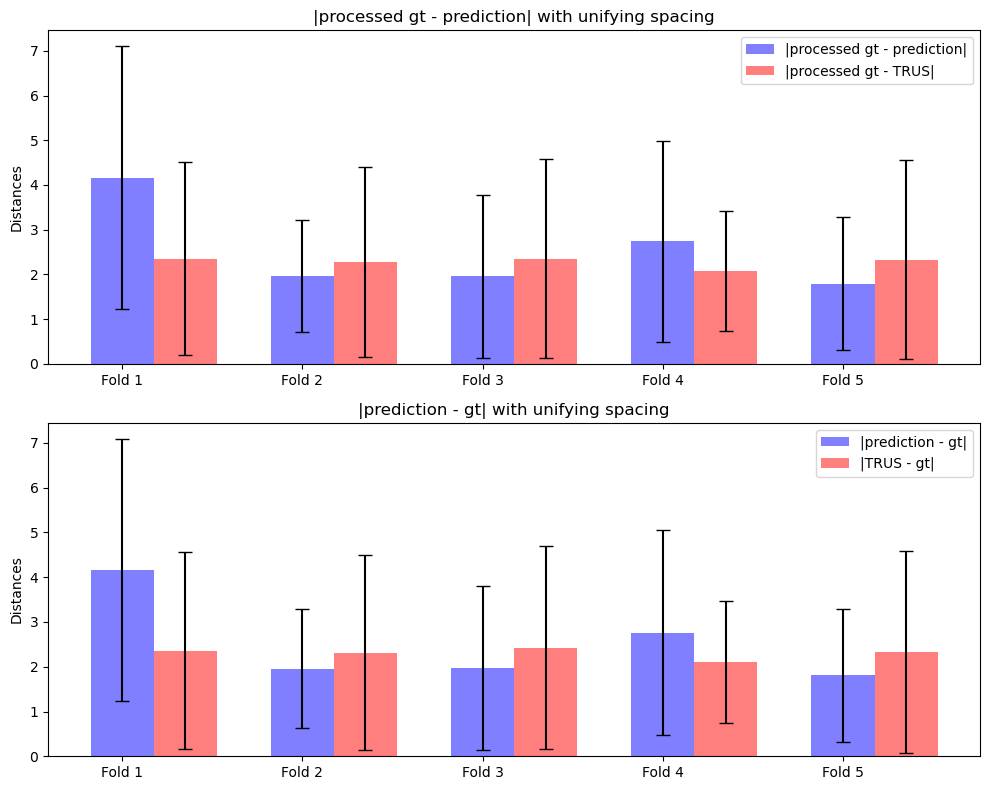

In [18]:
# 데이터 처리
mean_ac = []
std_ac = []

mean_ab = []
std_ab = []
mean_bc = []
std_bc = []
mean_ad = []
std_ad = []
mean_dc = []
std_dc = []

# Fold 수
num_folds = len(a_lists)

# fold별로 |a-b|와 |b-c| 계산
for fold_idx, (a_values, b_values, c_values) in enumerate(zip(a_lists, b_lists, c_lists), start=1):
    abs_diff_ac_fold = np.abs(np.array(a_values) - np.array(c_values))
    abs_diff_ab_fold = np.abs(np.array(a_values) - np.array(b_values))
    abs_diff_bc_fold = np.abs(np.array(b_values) - np.array(c_values))
    
    mean_ac_fold = np.mean(abs_diff_ac_fold)
    std_ac_fold = np.std(abs_diff_ac_fold)
    mean_ab_fold = np.mean(abs_diff_ab_fold)
    std_ab_fold = np.std(abs_diff_ab_fold)
    mean_bc_fold = np.mean(abs_diff_bc_fold)
    std_bc_fold = np.std(abs_diff_bc_fold)
    mean_ab.append(mean_ab_fold)
    std_ab.append(std_ab_fold)
    mean_bc.append(mean_bc_fold)
    std_bc.append(std_bc_fold)
    
    print(f"Fold {fold_idx}:")
    print(f"|processed gt - gt| 평균: {mean_ac_fold}")
    print(f"|processed gt - gt| 표준편차: {std_ac_fold}")
    print(f"|processed gt - prediction| 평균: {mean_ab_fold}")
    print(f"|processed gt - prediction| 표준편차: {std_ab_fold}")
    print(f"|prediction - gt| 평균: {mean_bc_fold}")
    print(f"|prediction - gt| 표준편차: {std_bc_fold}")
    print()

# fold별로 |a-d|와 |d-c| 계산 : fold마다 validation에 사용된 데이터가 다를거라서
for fold_idx, (a_values, d_values, c_values) in enumerate(zip(a_lists, d_lists, c_lists), start=1):
    abs_diff_ad_fold = np.abs(np.array(a_values) - np.array(d_values))
    abs_diff_dc_fold = np.abs(np.array(d_values) - np.array(c_values))
    
    mean_ad_fold = np.mean(abs_diff_ad_fold)
    std_ad_fold = np.std(abs_diff_ad_fold)
    mean_dc_fold = np.mean(abs_diff_dc_fold)
    std_dc_fold = np.std(abs_diff_dc_fold)
    mean_ad.append(mean_ad_fold)
    std_ad.append(std_ad_fold)
    mean_dc.append(mean_dc_fold)
    std_dc.append(std_dc_fold)
    
    print(f"Fold {fold_idx}:")
    print(f"|processed gt - TRUS| 평균: {mean_ad_fold}")
    print(f"|processed gt - TRUS| 표준편차: {std_ad_fold}")
    print(f"|TRUS - gt| 평균: {mean_dc_fold}")
    print(f"|TRUS - gt| 표준편차: {std_dc_fold}")
    print()
    
# Fold별 바 차트 그리기
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
bar_width = 0.35

# 첫 번째 plot
axes[0].bar(range(1, num_folds + 1), mean_ab, bar_width, yerr=std_ab, color='b', alpha=0.5, capsize=5, label='|processed gt - prediction|')
axes[0].bar([x + bar_width for x in range(1, num_folds + 1)], mean_ad, bar_width, color='r', yerr=std_ad, alpha=0.5, capsize=5, label='|processed gt - TRUS|')
axes[0].set_xticks(range(1, num_folds + 1))
axes[0].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
axes[0].set_ylabel('Distances')
axes[0].set_title('|processed gt - prediction| with unifying spacing')
axes[0].legend()

# 두 번째 plot
axes[1].bar(range(1, num_folds + 1), mean_bc, bar_width, yerr=std_bc, color='b', alpha=0.5, capsize=5, label='|prediction - gt|')
axes[1].bar([x + bar_width for x in range(1, num_folds + 1)], mean_dc, bar_width, yerr=std_dc, color='r', alpha=0.5, capsize=5, label='|TRUS - gt|')
axes[1].set_xticks(range(1, num_folds + 1))
axes[1].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
axes[1].set_ylabel('Distances')
axes[1].set_title('|prediction - gt| with unifying spacing')
axes[1].legend()

plt.tight_layout()
plt.show()

Mean: 2.5234549900002077 STD: 0.8837310701455)
Mean: 2.5342292664466264 STD: 0.8827613104587907)


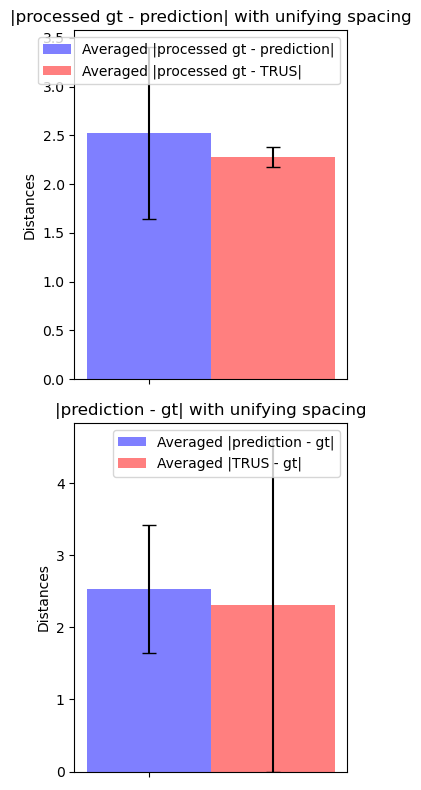

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(4, 8))
bar_width = 0.35
print(f'Mean: {np.mean(mean_ab)} STD: {np.std(mean_ab)})')
print(f'Mean: {np.mean(mean_bc)} STD: {np.std(mean_bc)})')

# 첫 번째 plot
axes[0].bar([1], [np.mean(mean_ab)], bar_width, yerr=[np.std(mean_ab)], color='b', alpha=0.5, capsize=5, label='Averaged |processed gt - prediction|')
axes[0].bar([1 + bar_width], [np.mean(mean_ad)], bar_width, color='r', yerr=[np.std(mean_ad)], alpha=0.5, capsize=5, label='Averaged |processed gt - TRUS|')
axes[0].set_xticks([1])
axes[0].set_xticklabels([''])
axes[0].set_ylabel('Distances')
axes[0].set_title('|processed gt - prediction| with unifying spacing')
axes[0].legend()

# 두 번째 plot
axes[1].bar([1], [np.mean(mean_bc)], bar_width, yerr=[np.std(mean_bc)], color='b', alpha=0.5, capsize=5, label='Averaged |prediction - gt|')
axes[1].bar([1 + bar_width], [np.mean(mean_dc)], bar_width, yerr=[np.mean(mean_dc)], color='r', alpha=0.5, capsize=5, label='Averaged |TRUS - gt|')
axes[1].set_xticks([1])
axes[1].set_xticklabels([''])
axes[1].set_ylabel('Distances')
axes[1].set_title('|prediction - gt| with unifying spacing')
axes[1].legend()

plt.tight_layout()
plt.show()

In [20]:
# # import os
# # import numpy as np

# # 디렉토리 경로 설정
# base_directory = '/data/hanyang_Prostate/Prostate/prostate_1c_test_result/test_230922_wo_spacing/'
# directory_paths = [os.path.join(base_directory, f'vnet_30000_fold{i}/training/') for i in range(1, 6)]
# directory_path_realgt = '/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/'

# # 초기화할 리스트
# a_lists = [[] for _ in range(5)]  # 각 폴드의 volume_gt 리스트
# b_lists = [[] for _ in range(5)]  # 각 폴드의 volume_pred 리스트
# c_lists = [[] for _ in range(5)]  # 각 폴드의 volume_realgt 리스트
# d_lists = [[] for _ in range(5)]  # 각 폴드의 volume_TRUS 리스트
# cnt = 0
# # 디렉토리별로 처리
# for fold_idx, directory_path in enumerate(directory_paths, start=1):
#     print("Directory: ", directory_path)
#     # 디렉토리 내의 모든 파일 검색
#     for filename in os.listdir(directory_path):
#         # 파일 이름이 "_gt.nii.gz"로 끝나는 경우에만 처리
#         if filename.endswith('_gt.nii.gz'):
#             # 파일의 전체 경로 생성
#             gt_file_path = os.path.join(directory_path, filename)
            
#             # 해당 _gt 파일과 동일한 이름 구조를 가진 _pred 파일 찾기
#             pred_filename = filename.replace('_gt.nii.gz', '_pred.nii.gz')
#             pred_file_path = os.path.join(directory_path, pred_filename)
    
#             # _pred 파일이 존재하면 계산 수행
#             if os.path.exists(pred_file_path):
#                 # _gt 파일의 정보를 읽어오고 volume 계산
#                 mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt = read_nifti_spacing_and_mask_count(gt_file_path)
#                 volume_gt = calculate_volume(mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt)
                
#                 # _pred 파일의 정보를 읽어오고 volume 계산
#                 mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred = read_nifti_spacing_and_mask_count(pred_file_path)
#                 volume_pred = calculate_volume(mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred)
                
#                 # 검색할 문자열 설정
#                 a_value = filename.split("_")[1]
    
#                 # /data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 내의 파일 검색
#                 for realgt_filename in os.listdir(directory_path_realgt):
#                     # 파일 이름에 검색할 문자열이 포함되어 있는지 확인
#                     if a_value in realgt_filename:
#                         mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt = read_nifti_spacing_and_mask_count(os.path.join(directory_path_realgt, realgt_filename))
#                         volume_realgt = calculate_volume(mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt)
                        
#                         # 값 저장
#                         if a_value in TRUS:
#                             cnt += 1
#                             a_lists[fold_idx - 1].append(volume_gt)
#                             b_lists[fold_idx - 1].append(volume_pred)
#                             c_lists[fold_idx - 1].append(volume_realgt)
#                             d_lists[fold_idx - 1].append(TRUS[a_value])
#                             # 출력
#                             print(f"No.: {a_value}")
#                             print(f"\t Volume (TRUS): {TRUS[a_value]}")
#                             print(f"\t Pixel Spacing X (realgt): {np.round(float(pixel_spacing_x_realgt),3)}")
#                             print(f"\t Volume (realgt): {np.round(volume_realgt,1)}")
#                             print(f"\t Pixel Spacing X (gt): {np.round(float(pixel_spacing_x_gt),3)}")
#                             print(f"\t Volume (gt): {np.round(volume_gt,1)}")
#                             print(f"\t Pixel Spacing X (pred): {np.round(float(pixel_spacing_x_pred),3)}")
#                             print(f"\t Volume (pred): {np.round(volume_pred,1)}")
#                             print("-----------------------------------------")
# print(cnt)

In [21]:
# # 데이터 처리
# mean_ab = []
# std_ab = []
# mean_bc = []
# std_bc = []
# mean_ad = []
# std_ad = []
# mean_dc = []
# std_dc = []

# # Fold 수
# num_folds = len(a_lists)

# # fold별로 |a-b|와 |b-c| 계산
# for fold_idx, (a_values, b_values, c_values) in enumerate(zip(a_lists, b_lists, c_lists), start=1):
#     abs_diff_ab_fold = np.abs(np.array(a_values) - np.array(b_values))
#     abs_diff_bc_fold = np.abs(np.array(b_values) - np.array(c_values))
    
#     mean_ab_fold = np.mean(abs_diff_ab_fold)
#     std_ab_fold = np.std(abs_diff_ab_fold)
#     mean_bc_fold = np.mean(abs_diff_bc_fold)
#     std_bc_fold = np.std(abs_diff_bc_fold)
#     mean_ab.append(mean_ab_fold)
#     std_ab.append(std_ab_fold)
#     mean_bc.append(mean_bc_fold)
#     std_bc.append(std_bc_fold)
    
#     print(f"Fold {fold_idx}:")
#     print(f"|processed gt - prediction| 평균: {mean_ab_fold}")
#     print(f"|processed gt - prediction| 표준편차: {std_ab_fold}")
#     print(f"|prediction - gt| 평균: {mean_bc_fold}")
#     print(f"|prediction - gt| 표준편차: {std_bc_fold}")
#     print()

# # fold별로 |a-d|와 |d-c| 계산 : fold마다 validation에 사용된 데이터가 다를거라서
# for fold_idx, (a_values, d_values, c_values) in enumerate(zip(a_lists, d_lists, c_lists), start=1):
#     abs_diff_ad_fold = np.abs(np.array(a_values) - np.array(d_values))
#     abs_diff_dc_fold = np.abs(np.array(d_values) - np.array(c_values))
    
#     mean_ad_fold = np.mean(abs_diff_ad_fold)
#     std_ad_fold = np.std(abs_diff_ad_fold)
#     mean_dc_fold = np.mean(abs_diff_dc_fold)
#     std_dc_fold = np.std(abs_diff_dc_fold)
#     mean_ad.append(mean_ad_fold)
#     std_ad.append(std_ad_fold)
#     mean_dc.append(mean_dc_fold)
#     std_dc.append(std_dc_fold)
    
#     print(f"Fold {fold_idx}:")
#     print(f"|processed gt - TRUS| 평균: {mean_ad_fold}")
#     print(f"|processed gt - TRUS| 표준편차: {std_ad_fold}")
#     print(f"|TRUS - gt| 평균: {mean_dc_fold}")
#     print(f"|TRUS - gt| 표준편차: {std_dc_fold}")
#     print()
    
# # Fold별 바 차트 그리기
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))
# bar_width = 0.35

# # 첫 번째 plot
# axes[0].bar(range(1, num_folds + 1), mean_ab, bar_width, yerr=std_ab, color='b', alpha=0.5, capsize=5, label='|processed gt - prediction|')
# axes[0].bar([x + bar_width for x in range(1, num_folds + 1)], mean_ad, bar_width, color='r', yerr=std_ad, alpha=0.5, capsize=5, label='|processed gt - TRUS|')
# axes[0].set_xticks(range(1, num_folds + 1))
# axes[0].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
# axes[0].set_ylabel('Distances')
# axes[0].set_title('|processed gt - prediction| VS |processed gt - TRUS| wo unifying spacing')
# axes[0].legend()

# # 두 번째 plot
# axes[1].bar(range(1, num_folds + 1), mean_bc, bar_width, yerr=std_bc, color='b', alpha=0.5, capsize=5, label='|prediction - gt|')
# axes[1].bar([x + bar_width for x in range(1, num_folds + 1)], mean_dc, bar_width, yerr=std_dc, color='r', alpha=0.5, capsize=5, label='|TRUS - gt|')
# axes[1].set_xticks(range(1, num_folds + 1))
# axes[1].set_xticklabels([f'Fold {i}' for i in range(1, num_folds + 1)])
# axes[1].set_ylabel('Distances')
# axes[1].set_title('|prediction - gt| VS |TRUS - gt| wo unifying spacing')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

### 가장 성능이 좋았던 fold2의 모델을 가지고 전체 labeled data에 대한 segmentation 수행 후 volume 추정

In [22]:
# # import os

# # 디렉토리 경로 설정
# directory_path = '/data/hanyang_Prostate/Prostate/prostate_1c_test_result/test_230922_bestmodel_total_w_spacing/bestmodel_230922/'
# directory_path_realgt = '/data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/'

# a = [] # volume_gt list
# b = [] # volume_pred list
# c = [] # volume_realgt list
# d = [] # volume_TRUS
# cnt = 0
# # 디렉토리 내의 모든 파일 검색
# for filename in os.listdir(directory_path):
#     # 파일 이름이 "_gt.nii.gz"로 끝나는 경우에만 처리
#     if filename.endswith('_gt.nii.gz'):
#         # 파일의 전체 경로 생성
#         gt_file_path = os.path.join(directory_path, filename)
        
#         # 해당 _gt 파일과 동일한 이름 구조를 가진 _pred 파일 찾기
#         pred_filename = filename.replace('_gt.nii.gz', '_pred.nii.gz')
#         pred_file_path = os.path.join(directory_path, pred_filename)

#         # _pred 파일이 존재하면 계산 수행
#         if os.path.exists(pred_file_path):
#             # _gt 파일의 정보를 읽어오고 volume 계산
#             mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt = read_nifti_spacing_and_mask_count(gt_file_path)
#             volume_gt = calculate_volume(mask_voxel_count_gt, pixel_spacing_x_gt, pixel_spacing_y_gt, slice_gap_gt)
            
#             # _pred 파일의 정보를 읽어오고 volume 계산
#             mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred = read_nifti_spacing_and_mask_count(pred_file_path)
#             volume_pred = calculate_volume(mask_voxel_count_pred, pixel_spacing_x_pred, pixel_spacing_y_pred, slice_gap_pred)
            
#             # 검색할 문자열 설정
#             a_value = filename.split("_")[1]

#             # /data/hanyang_Prostate/50_example/original/1_50_trim_20230130/Total volume/ 디렉토리 내의 파일 검색
#             for realgt_filename in os.listdir(directory_path_realgt):
#                 # 파일 이름에 검색할 문자열이 포함되어 있는지 확인
#                 if a_value in realgt_filename:
#                     mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt = read_nifti_spacing_and_mask_count(os.path.join(directory_path_realgt,realgt_filename))
#                     volume_realgt = calculate_volume(mask_voxel_count_realgt, pixel_spacing_x_realgt, pixel_spacing_y_realgt, slice_gap_realgt)
                    
#                     if a_value in TRUS:
#                         cnt += 1
#                         # 값 저장
#                         a.append(volume_gt)
#                         b.append(volume_pred)
#                         c.append(volume_realgt)
#                         d.append(TRUS[a_value])
#                         # 출력
#                         print(f"No.: {a_value}")
#                         print(f"\t Volume (TRUS): {TRUS[a_value]}")
#                         print(f"\t Pixel Spacing X (realgt): {np.round(float(pixel_spacing_x_realgt),3)}")
#                         print(f"\t Volume (realgt): {np.round(volume_realgt,1)}")
#                         print(f"\t Pixel Spacing X (gt): {np.round(float(pixel_spacing_x_gt),3)}")
#                         print(f"\t Volume (gt): {np.round(volume_gt,1)}")
#                         print(f"\t Pixel Spacing X (pred): {np.round(float(pixel_spacing_x_pred),3)}")
#                         print(f"\t Volume (pred): {np.round(volume_pred,1)}")
#                         print("-----------------------------------------")
                    
# # |a-b|와 |b-c| 계산
# abs_diff_ab = np.abs(np.array(a) - np.array(b))
# abs_diff_bc = np.abs(np.array(b) - np.array(c))

# # |a-d|와 |d-c| 계산
# abs_diff_ad = np.abs(np.array(a) - np.array(d))
# abs_diff_dc = np.abs(np.array(d) - np.array(c))

# # 평균과 표준편차 계산
# mean_ab = np.mean(abs_diff_ab)
# std_ab = np.std(abs_diff_ab)
# mean_bc = np.mean(abs_diff_bc)
# std_bc = np.std(abs_diff_bc)

# # 결과 출력
# print(f"|a-b| 평균: {mean_ab}")
# print(f"|a-b| 표준편차: {std_ab}")
# print(f"|b-c| 평균: {mean_bc}")
# print(f"|b-c| 표준편차: {std_bc}")
# print()

# # 평균과 표준편차 계산
# mean_ad = np.mean(abs_diff_ad)
# std_ad = np.std(abs_diff_ad)
# mean_dc = np.mean(abs_diff_dc)
# std_dc = np.std(abs_diff_dc)

# # 결과 출력
# print(f"|a-d| 평균: {mean_ad}")
# print(f"|a-d| 표준편차: {std_ad}")
# print(f"|d-c| 평균: {mean_dc}")
# print(f"|d-c| 표준편차: {std_dc}")
# print()
# print(cnt)

In [23]:
# fig, axes = plt.subplots(2, 1, figsize=(4, 8))
# bar_width = 0.35

# # 첫 번째 plot
# axes[0].bar([1], [mean_ab], bar_width, yerr=[std_ab], color='b', alpha=0.5, capsize=5, label='|processed gt - prediction|')
# axes[0].bar([1 + bar_width], [mean_ad], bar_width, color='r', yerr=[std_ad], alpha=0.5, capsize=5, label='|processed gt - TRUS|')
# axes[0].set_xticks([1])
# axes[0].set_xticklabels([''])
# axes[0].set_ylabel('Distances')
# axes[0].set_title('|processed gt - prediction| VS |processed gt - TRUS| with unifying spacing')
# axes[0].legend()

# # 두 번째 plot
# axes[1].bar([1], [mean_bc], bar_width, yerr=[std_bc], color='b', alpha=0.5, capsize=5, label='|prediction - gt|')
# axes[1].bar([1 + bar_width], [mean_dc], bar_width, yerr=[std_dc], color='r', alpha=0.5, capsize=5, label='|TRUS - gt|')
# axes[1].set_xticks([1])
# axes[1].set_xticklabels([''])
# axes[1].set_ylabel('Distances')
# axes[1].set_title('|prediction - gt| VS |TRUS - gt| with unifying spacing')
# axes[1].legend()

# plt.tight_layout()
# plt.show()

In [24]:
# # import numpy as np
# # import matplotlib.pyplot as plt
# from scipy import stats

# # correlation coefficient 계산 및 출력
# corr_ac = np.corrcoef(a, c)[0, 1]
# corr_ab = np.corrcoef(a, b)[0, 1]
# corr_cb = np.corrcoef(c, b)[0, 1]
# corr_ad = np.corrcoef(a, d)[0, 1]
# corr_cd = np.corrcoef(c, d)[0, 1]

# print(f'Correlation coefficient (a vs. c): {corr_ac:.2f}')
# print(f'Correlation coefficient (a vs. b): {corr_ab:.2f}')
# print(f'Correlation coefficient (c vs. b): {corr_cb:.2f}')
# print(f'Correlation coefficient (a vs. d): {corr_ad:.2f}')
# print(f'Correlation coefficient (c vs. d): {corr_cd:.2f}')

# # least square linear fit 계산 및 출력
# slope_ac, intercept_ac, r_value_ac, p_value_ac, std_err_cb = stats.linregress(a, c)
# slope_ab, intercept_ab, r_value_ab, p_value_ab, std_err_ab = stats.linregress(a, b)
# slope_cb, intercept_cb, r_value_cb, p_value_cb, std_err_cb = stats.linregress(c, b)
# slope_ad, intercept_ad, r_value_ad, p_value_ad, std_err_ad = stats.linregress(a, d)
# slope_cd, intercept_cd, r_value_cd, p_value_cd, std_err_cd = stats.linregress(c, d)

# print(f'Linear Fit Parameters (a vs. c): slope={slope_ac:.2f}, intercept={intercept_ac:.2f}')
# print(f'Linear Fit Parameters (a vs. b): slope={slope_ab:.2f}, intercept={intercept_ab:.2f}')
# print(f'Linear Fit Parameters (c vs. b): slope={slope_cb:.2f}, intercept={intercept_cb:.2f}')
# print(f'Linear Fit Parameters (a vs. d): slope={slope_ad:.2f}, intercept={intercept_ad:.2f}')
# print(f'Linear Fit Parameters (c vs. d): slope={slope_cd:.2f}, intercept={intercept_cd:.2f}')

# # r-squared 계산 및 출력
# r_squared_ac = r_value_ac**2
# r_squared_ab = r_value_ab**2
# r_squared_cb = r_value_cb**2
# r_squared_ad = r_value_ad**2
# r_squared_cd = r_value_cd**2

# print(f'R-squared (a vs. c): {r_squared_ac:.2f}')
# print(f'R-squared (a vs. b): {r_squared_ab:.2f}')
# print(f'R-squared (c vs. b): {r_squared_cb:.2f}')
# print(f'R-squared (a vs. d): {r_squared_ad:.2f}')
# print(f'R-squared (c vs. d): {r_squared_cd:.2f}')

# # a와 c 간의 산점도
# plt.figure(figsize=(6,6))
# plt.scatter(a, c, s=50, edgecolor='b', facecolor='b', alpha=0.5, label='datum')
# plt.ylim(0,60)
# plt.xlim(0,60)
# plt.xlabel("Processed GT volume")
# plt.ylabel("GT volume")
# # x=y 선 그리기 (점선)
# plt.plot([0,60], [0,60], linestyle='--', color='gray', label='Ideal model')
# plt.plot(np.array(a), slope_ac * np.array(a) + intercept_ac, color='black', label=f'Linear Fit (y={slope_ac:.2f}x+{intercept_ac:.2f})')
# # Correlation coefficient와 r-squared 값 출력
# corr_coefficient_text = f'Corr Coef.: {corr_ac:.2f}'
# r_squared_text = f'R-squared: {r_squared_ac:.2f}'
# plt.text(0.7, 0.1, corr_coefficient_text, c='b', transform=plt.gca().transAxes)
# plt.text(0.7, 0.05, r_squared_text, c='b', transform=plt.gca().transAxes)
# # 그래프 표시
# plt.legend()
# plt.show()


# # a와 b 간의 산점도
# plt.figure(figsize=(6,6))
# plt.scatter(a, b, s=50, edgecolor='b', facecolor='b', alpha=0.5, label='datum')
# plt.ylim(0,60)
# plt.xlim(0,60)
# plt.xlabel("Processed GT volume")
# plt.ylabel("Predicted volume")
# # x=y 선 그리기 (점선)
# plt.plot([0,60], [0,60], linestyle='--', color='gray', label='Ideal model')
# plt.plot(np.array(a), slope_ab * np.array(a) + intercept_ab, color='black', label=f'Linear Fit (y={slope_ab:.2f}x+{intercept_ab:.2f})')
# # Correlation coefficient와 r-squared 값 출력
# corr_coefficient_text = f'Corr Coef.: {corr_ab:.2f}'
# r_squared_text = f'R-squared: {r_squared_ab:.2f}'
# plt.text(0.7, 0.1, corr_coefficient_text, c='b', transform=plt.gca().transAxes)
# plt.text(0.7, 0.05, r_squared_text, c='b', transform=plt.gca().transAxes)
# # 그래프 표시
# plt.legend()
# plt.show()

# plt.figure(figsize=(6,6))
# # b와 c 간의 산점도
# plt.scatter(c, b, s=50, edgecolor='b', facecolor='b', alpha=0.5, label='datum')
# plt.ylim(0,60)
# plt.xlim(0,60)
# plt.xlabel("GT volume")
# plt.ylabel("Predicted volume")
# # x=y 선 그리기 (점선)
# plt.plot([0,60], [0,60], linestyle='--', color='gray', label='Ideal model')
# plt.plot(np.array(c), slope_cb * np.array(c) + intercept_cb, color='black', label=f'Linear Fit (y={slope_cb:.2f}x+{intercept_cb:.2f})')
# # Correlation coefficient와 r-squared 값 출력
# corr_coefficient_text = f'Corr Coef.: {corr_cb:.2f}'
# r_squared_text = f'R-squared: {r_squared_cb:.2f}'
# plt.text(0.7, 0.1, corr_coefficient_text, c='b', transform=plt.gca().transAxes)
# plt.text(0.7, 0.05, r_squared_text, c='b', transform=plt.gca().transAxes)
# # 그래프 표시
# plt.legend()
# plt.show()

# plt.figure(figsize=(6,6))
# # a와 d 간의 산점도
# plt.scatter(a, d, s=50, edgecolor='b', facecolor='b', alpha=0.5, label='datum')
# plt.ylim(0,60)
# plt.xlim(0,60)
# plt.xlabel("x = Processed GT volume")
# plt.ylabel("y = TRUS volume")
# # x=y 선 그리기 (점선)
# plt.plot([0,60], [0,60], linestyle='--', color='gray', label='Ideal model')
# plt.plot(np.array(a), slope_ad * np.array(a) + intercept_ad, color='black', label=f'Linear Fit (y hat={slope_ad:.2f}x+{intercept_ad:.2f})')
# # Correlation coefficient와 r-squared 값 출력
# corr_coefficient_text = f'Corr Coef.: {corr_ad:.2f}'
# r_squared_text = f'R-squared: {r_squared_ad:.2f}'
# plt.text(0.7, 0.1, corr_coefficient_text, c='b', transform=plt.gca().transAxes)
# plt.text(0.7, 0.05, r_squared_text, c='b', transform=plt.gca().transAxes)
# # 그래프 표시
# plt.legend()
# plt.show()

# plt.figure(figsize=(6,6))
# # c와 d 간의 산점도
# plt.scatter(c, d, s=50, edgecolor='b', facecolor='b', alpha=0.5, label='datum')
# plt.ylim(0,60)
# plt.xlim(0,60)
# plt.xlabel("x = GT volume")
# plt.ylabel("y = TRUS volume")
# # x=y 선 그리기 (점선)
# plt.plot([0,60], [0,60], linestyle='--', color='gray', label='Ideal model')
# plt.plot(np.array(c), slope_cd * np.array(c) + intercept_cd, color='black', label=f'Linear Fit (y hat={slope_cd:.2f}x+{intercept_cd:.2f})')
# # Correlation coefficient와 r-squared 값 출력
# corr_coefficient_text = f'Corr Coef.: {corr_cd:.2f}'
# r_squared_text = f'R-squared: {r_squared_cd:.2f}'
# plt.text(0.7, 0.1, corr_coefficient_text, c='b', transform=plt.gca().transAxes)
# plt.text(0.7, 0.05, r_squared_text, c='b', transform=plt.gca().transAxes)
# # 그래프 표시
# plt.legend()
# plt.show()

### 원본 데이터의 Spacing 분포 히스토그램 및 통계값 확인

Mean: 0.7736938775510205
Median: 0.782
Standard Deviation: 0.03823461626436135
Min: 0.656
Max: 0.866


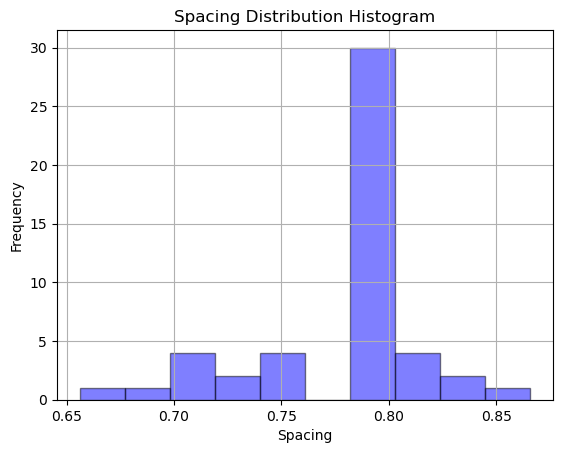

In [25]:
dist_spacing = np.array([0.782, 0.755, 0.709, 0.782, 0.782, 0.782, 0.782, 0.732, 0.782, 0.709, 0.782, 0.782, 0.824, 0.782, 0.782, 0.782, 0.782, 0.656, 0.782, 0.782, 0.782, 0.782, 0.782, 0.732, 0.816, 0.782, 0.782, 0.782, 0.782, 0.782, 0.866, 0.782, 0.743, 0.717, 0.74, 0.74, 0.782, 0.709, 0.831, 0.782, 0.816, 0.782, 0.801, 0.782, 0.835, 0.682, 0.82, 0.782, 0.782])


# 히스토그램 생성
plt.hist(dist_spacing, facecolor='b', alpha=0.5, bins=10, edgecolor='k')
plt.xlabel('Spacing')
plt.ylabel('Frequency')
plt.title('Spacing Distribution Histogram')
plt.grid(True)

# 통계값 계산
mean_value = np.mean(dist_spacing)
median_value = np.median(dist_spacing)
std_deviation = np.std(dist_spacing)
min_value = np.min(dist_spacing)
max_value = np.max(dist_spacing)

# 통계값 출력
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")

# 그래프 표시
plt.show()